# Volume Sampling vs projection DPP for low rank approximation
## Introduction
#### In this notebook we compare the volume sampling and projection DPP for low rank approximation.
We recall the result proved in the article [DRVW]:\\
Let S be a random subset of k columns of X chosen with probability: $$P(S) = \frac{1}{Z_{k}} det(X_{.,S}^{T}X_{.,S})$$ with $$Z_{k} = \sum\limits_{S \subset [N], |S| = k} det(X_{.,S}^{T}X_{.,S})$$
Then
$$\begin{equation}
E(\| X - \pi_{X_{.,S}}(X) \|_{Fr}^{2}) \leq (k+1)\| X - \pi_{k}(X) \|_{Fr}^{2}
\end{equation}$$


We can prove that the volume sampling distribution is a mixture of projection DPPs distributions..., in particular one projection DPP distribution stands out for the problem of low rank approximation: ....\\
For the moment, there is no analytical expression for $$\begin{equation}
E(\| X - \pi_{X_{.,S}}(X) \|_{Fr}^{2}) 
\end{equation}$$ under the distribution of projection DPP.\\
However, we can calculate this quantity using simulation on some matrices representing cloud points with some specific geometric constraints.

## I- Generating a cloud of points with geometric constraints
Let $$X \in R^{n \times m}$$ a matrix representing a cloud of points.
We can write the SVD of $$X = UDV^{T}$$


#### References
[DRVW] Deshpande, Amit and Rademacher, Luis and Vempala, Santosh and Wang, Grant - Matrix Approximation and Projective Clustering via Volume Sampling 2006

In [1]:
import numpy as np
from itertools import combinations
from scipy.stats import binom
import scipy.special
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display, HTML

### I-1- Givens Rotations generators
The function

In [2]:
def t_func(q_i,q_j,q_ij,l_i,l_j): 
    # t in section 3.1 Dhillon (2005) 
    delta = np.power(q_ij,2)-(q_i-l_i)*(q_j-l_i)
    if delta<0:
        print(delta)
        print("error sqrt")
    t = q_ij - np.sqrt(delta) 
    t = t/(q_j-l_i)
    return t
     
def G_func(i,j,q_i,q_j,q_ij,l_i,l_j,N): 
    # Gitens Rotation 
    G=np.eye(N) 
    t = t_func(q_i,q_j,q_ij,l_i,l_j)
    c = 1/(np.sqrt(np.power(t,2)+1))
    s = t*c
    G[i,i]=c
    G[i,j]=s 
    G[j,i]= -s
    G[j,j]= c
    return G

The following function is an implementation of the algorithm [] figuring in the article [] to generate an orthogonal matrix with a prescribed profile of leverage scores.
In fact this is a simplification of the algorithm .....

In [3]:
def generate_orthonormal_matrix_with_leverage_scores(N,d,lv_scores_vector,versions_number):
    #Transforming an idendity matrix to an orthogonal matrix with prescribed lengths
    Q = np.zeros((N,d))
    previous_Q = np.zeros((versions_number,N,d))
    versionning_period = (int)(N/versions_number)
    for _ in range(0,d):
        Q[_,_] = 1

    I_sorting =  list(reversed(np.argsort(lv_scores_vector)))
    lv_scores_vector = np.asarray(list(reversed(np.sort(lv_scores_vector))))

    i = d-1
    j = d
    v_counter =0
    for t in range(N-1):
        delta_i = np.abs(lv_scores_vector[i] - np.power(np.linalg.norm(Q[i,:]),2))
        delta_j = np.abs(lv_scores_vector[j] - np.power(np.linalg.norm(Q[j,:]),2))
        q_i = np.power(np.linalg.norm(Q[i,:]),2)
        q_j = np.power(np.linalg.norm(Q[j,:]),2)
        q_ij = np.dot(Q[i,:],Q[j,:].T)
        l_i = lv_scores_vector[i]
        l_j = lv_scores_vector[j]
        G = np.eye(N)
        if t%versionning_period ==0:
            previous_Q[v_counter,:,:] = Q
            v_counter = v_counter +1
        if delta_i <= delta_j:
            l_k = q_i + q_j -l_i
            G = G_func(i,j,q_i,q_j,q_ij,l_i,l_k,N)
            Q = np.dot(G,Q)
            i = i-1
        else:
            l_k = q_i + q_j -l_j
            G = G_func(i,j,q_j,q_i,q_ij,l_j,l_k,N)
            Q = np.dot(G,Q)
            j = j+1

    return Q,previous_Q

The following function allows to estimate the leverage scores for an orthogonal matrix Q: the function calculates the diagonoal of the matrix $$Q Q^{T}$$

In [4]:
def estimate_leverage_scores_from_orthogonal_matrix(Q):
    [N,_] = np.shape(Q)
    lv_scores_vector = np.zeros((N,1))
    lv_scores_vector = np.diag(np.dot(Q,np.transpose(Q)))
    lv_scores_vector = np.asarray(list(reversed(np.sort(lv_scores_vector))))
    return lv_scores_vector
def estimate_sum_first_k_leverage_scores(Q,k):
    lv_scores_vector = estimate_leverage_scores_from_orthogonal_matrix(Q)
    res = np.sum(lv_scores_vector[0:k])
    return res

## I-2- Application of the algorithm
We use the previous function (generate_orthonormal_matrix_with_leverage_scores) to generate a cloud of points represented by an orthogonal matrix Q and we keep a track of the evolution of the matrix Q in the algorithm: at the beginning Q is the rectangular identity matrix (the first d rows are the vectors of canonical basis and the other rows are zeros) the algorithm apply a Givens rotation to Q at each step and at the end the resulting matrix is an orthogonal matrix with the presribed leverage scores.
In this example we request a matrix Q with a uniform profil of leverage scores and we keep 5 matrices representing the 'history' of the matrix Q in the algorithm: the most important property of these 5 matrices is that their leverage score profiles are decreasing with respect to the Schur-order or (the majorization).
The number of points is 100 and the dimension of the space is 2.

In [5]:
real_dim = 10
k = 4
r = 5
versions_number = 5
lv_scores_vector = k/real_dim*np.ones(real_dim)
[Q,previous_Q] = generate_orthonormal_matrix_with_leverage_scores(real_dim,k,lv_scores_vector,versions_number)

In [6]:
# Note: If we change versions_number we have to change the number of the lv_i
lv_0 = estimate_leverage_scores_from_orthogonal_matrix(previous_Q[0,:,:])
lv_1 = estimate_leverage_scores_from_orthogonal_matrix(previous_Q[1,:,:])
lv_2 = estimate_leverage_scores_from_orthogonal_matrix(previous_Q[2,:,:])
lv_3 = estimate_leverage_scores_from_orthogonal_matrix(previous_Q[3,:,:])
lv_4 = estimate_leverage_scores_from_orthogonal_matrix(previous_Q[4,:,:])
lv_5 = estimate_leverage_scores_from_orthogonal_matrix(Q)
index_list = list(range(real_dim))

In this example the objective is Q and the initialization is Q_1 (the rectangular identity)
We have with respect to the Schur-order (or the majorization):
$$Q \prec_{S} Q_5 \prec_{S} Q_4 \prec_{S} Q_3 \prec_{S} Q_2 \prec_{S} Q_1 $$

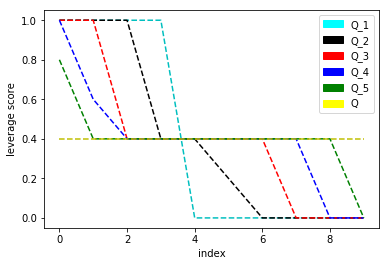

In [7]:
plt.plot(index_list[0:10], lv_0[0:10], 'c--',index_list[0:10], lv_1[0:10], 'k--', index_list[0:10], lv_2[0:10], 'r--', index_list[0:10], lv_3[0:10], 'b--',index_list[0:10], lv_4[0:10], 'g--',index_list[0:10], lv_5[0:10], 'y--')
plt.xlabel('index')
plt.ylabel('leverage score')
cyan_patch = mpatches.Patch(color='cyan', label='Q_1')
black_patch = mpatches.Patch(color='black', label='Q_2')
red_patch = mpatches.Patch(color='red', label='Q_3')
blue_patch = mpatches.Patch(color='blue', label='Q_4')
green_patch = mpatches.Patch(color='green', label='Q_5')
yellow_patch = mpatches.Patch(color='yellow', label='Q')
plt.legend(handles=[cyan_patch,black_patch,red_patch,blue_patch,green_patch,yellow_patch])

plt.show()

## I-3- Extending the orthogonal matrices

For the task of low rank approximation, we have seen that only the information contained in the first right k eigenvectors of the matrix X are relevant. In the previous step we build only the first right k eigenvectors but we still need to complete these orthogonal matrices with d-k columns. We proceed as following:
Generate a random vector (Nx1) using independent standard gaussian variables,
Project this vector in the orthogonal of the span of Q
Normalize the obtained vector after the projection
Extend the matrix Q
Note that this procedure is not the unique way to extend the matrix Q to an orthogonal (Nxd) matrix.

In [8]:
def extend_orthogonal_matrix(Q,d_target):
    [N,d] = np.shape(Q)
    Q_target = np.zeros((N,d))
    Q_target = Q
    delta = d_target - d
    for t in range(delta):
        Q_test = np.random.normal(0, 1, N)
        for _ in range(d):
            Q_test = Q_test - np.dot(Q_test,Q[:,_])*Q[:,_]
        Q_test = Q_test/np.linalg.norm(Q_test)
        Q_test = Q_test.reshape(N,1)
        Q_target = np.append(Q_target,Q_test,1)
    return Q_target

#extended_Q = extend_orthogonal_matrix(Q,r)

## I-4 - Constructing a dataset for every extended orthogonal matrix 
The previous step allow us to build (N x d) orthogonal matrices such that the extracted (N x k) matrix have a prescribed profile of leverage scores.
Now we construct a cloud of point by assigning a covariance matrix D and a matrix V

In [9]:
N = 100
mean = np.zeros((real_dim))
cov_test = 0.1*np.ones((real_dim-r))
cov = np.diag(np.concatenate(([10,10,4,1,0.1],cov_test)))
def contruct_dataset_from_orthogonal_matrix(multi_Q,N,target_d,cov,mean,versions_number):
    multi_X = np.zeros((versions_number,N,real_dim))
    for t in range(versions_number):
        test_X = np.random.multivariate_normal(mean, cov, N)
        [U,_,_] = np.linalg.svd(test_X, full_matrices=False)
        Q_test = extend_orthogonal_matrix(multi_Q[t,:,:],target_d)
        multi_X[t,:,:] = np.dot(np.dot(Q_test,cov),U.T).T
    return multi_X



In [10]:
multi_X = contruct_dataset_from_orthogonal_matrix(previous_Q,N,real_dim,cov,mean,versions_number)

## II- Volume sampling vs Projection DPP for low rank approximation

In [11]:
def approximation_error_function(V,Sigma,k,X_S):
    d = list(Sigma.shape)[0]
    Sigma = np.multiply(Sigma,Sigma)
    sub_V,_,_ = np.linalg.svd(X_S, full_matrices=False)
    H_hat = np.dot(V.T,sub_V)
    r_vector = np.ones(d) - np.multiply(np.linalg.norm(H_hat,axis = 1),np.linalg.norm(H_hat,axis = 1))
    approximation_error_ratio= np.sqrt(np.sum(np.multiply(Sigma,r_vector))/np.sum(Sigma[k:d]))
    return approximation_error_ratio

In [12]:
def approximation_error_function_2(Sigma,k,X,X_S):
    d = list(Sigma.shape)[0]
    Sigma = np.multiply(Sigma,Sigma)
    sigma_S_temp = np.linalg.inv(np.dot(X_S.T,X_S))
    projection_S = np.dot(np.dot(X_S,sigma_S_temp),X_S.T)
    res_X = X - np.dot(projection_S,X)
    approximation_error_ratio = np.power(np.linalg.norm(res_X,'fro'),2)/np.sum(Sigma[k:d])
    return approximation_error_ratio

In [13]:
def probability_approximation_error_for_projection_DPP(X,U,k,N,epsilon):
    V,Sigma,_ = np.linalg.svd(X, full_matrices=False)
    volumes_array = [np.abs(np.linalg.det(np.dot(U[:,list(comb)].T,U[:,list(comb)]))) for comb in combinations(range(N),k)]
    volumes_array_sum = np.sum(volumes_array)
    volumes_array = volumes_array/volumes_array_sum
    #approximation_error_array = [approximation_error_function(V,Sigma,k,X[:,list(comb)]) for comb in combinations(range(N),k)]
    approximation_error_array = [approximation_error_function_2(Sigma,k,X,X[:,list(comb)]) for comb in combinations(range(N),k)]
    indices_below_epsilon = [index for index,test in enumerate(combinations(range(N),k)) if approximation_error_array[index] < 1+epsilon]
    probability_below_epsilon = np.sum(volumes_array[indices_below_epsilon])

    return probability_below_epsilon

## II-1 Cumulative distribution function of the approximation error for a sampling scheme

In [14]:
k = 4
epsilons_array = np.arange(0, 8, 0.25)
number_of_epsilons = list(epsilons_array.shape)[0]
probability_array_U_0 = np.zeros(number_of_epsilons)
probability_array_X_0 = np.zeros(number_of_epsilons)
probability_array_U_1 = np.zeros(number_of_epsilons)
probability_array_X_1 = np.zeros(number_of_epsilons)
probability_array_U_2 = np.zeros(number_of_epsilons)
probability_array_X_2 = np.zeros(number_of_epsilons)
probability_array_U_3 = np.zeros(number_of_epsilons)
probability_array_X_3 = np.zeros(number_of_epsilons)
probability_array_U_4 = np.zeros(number_of_epsilons)
probability_array_X_4 = np.zeros(number_of_epsilons)
U_0 = previous_Q[0,:,:].T
U_1 = previous_Q[1,:,:].T
U_2 = previous_Q[2,:,:].T
U_3 = previous_Q[3,:,:].T
U_4 = previous_Q[4,:,:].T
X_0 = multi_X[0,:,:]
X_1 = multi_X[1,:,:]
X_2 = multi_X[2,:,:]
X_3 = multi_X[3,:,:]
X_4 = multi_X[4,:,:]


In [15]:
for i in range(number_of_epsilons):
    probability_array_X_0[i] = probability_approximation_error_for_projection_DPP(X_0,X_0,k,real_dim,epsilons_array[i])
    probability_array_U_0[i] = probability_approximation_error_for_projection_DPP(X_0,U_0[0:k, :],k,real_dim,epsilons_array[i])
    probability_array_X_1[i] = probability_approximation_error_for_projection_DPP(X_1,X_1,k,real_dim,epsilons_array[i])
    probability_array_U_1[i] = probability_approximation_error_for_projection_DPP(X_1,U_1[0:k, :],k,real_dim,epsilons_array[i])
    probability_array_X_2[i] = probability_approximation_error_for_projection_DPP(X_2,X_2,k,real_dim,epsilons_array[i])
    probability_array_U_2[i] = probability_approximation_error_for_projection_DPP(X_2,U_2[0:k, :],k,real_dim,epsilons_array[i])
    probability_array_X_3[i] = probability_approximation_error_for_projection_DPP(X_3,X_3,k,real_dim,epsilons_array[i])
    probability_array_U_3[i] = probability_approximation_error_for_projection_DPP(X_3,U_3[0:k, :],k,real_dim,epsilons_array[i])
    probability_array_X_4[i] = probability_approximation_error_for_projection_DPP(X_4,X_4,k,real_dim,epsilons_array[i])
    probability_array_U_4[i] = probability_approximation_error_for_projection_DPP(X_4,U_4[0:k, :],k,real_dim,epsilons_array[i])
           

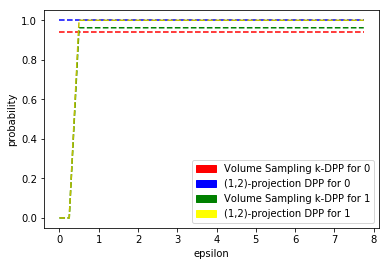

In [16]:
plt.plot(epsilons_array, probability_array_X_0, 'r--', epsilons_array, probability_array_U_0, 'b--',epsilons_array, probability_array_X_1, 'g--',epsilons_array, probability_array_U_1, 'y--')
plt.xlabel('epsilon')
plt.ylabel('probability')

red_patch = mpatches.Patch(color='red', label='Volume Sampling k-DPP for 0')
blue_patch = mpatches.Patch(color='blue', label='(1,2)-projection DPP for 0')
green_patch = mpatches.Patch(color='green', label='Volume Sampling k-DPP for 1')
yellow_patch = mpatches.Patch(color='yellow', label='(1,2)-projection DPP for 1')

plt.legend(handles=[red_patch,blue_patch,green_patch,yellow_patch])

plt.show()

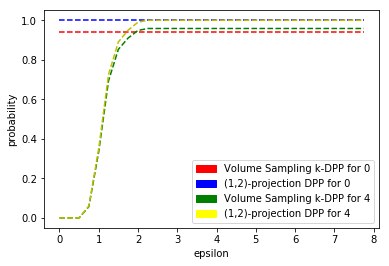

In [17]:
plt.plot(epsilons_array, probability_array_X_0, 'r--', epsilons_array, probability_array_U_0, 'b--',epsilons_array, probability_array_X_4, 'g--',epsilons_array, probability_array_U_4, 'y--')
plt.xlabel('epsilon')
plt.ylabel('probability')

red_patch = mpatches.Patch(color='red', label='Volume Sampling k-DPP for 0')
blue_patch = mpatches.Patch(color='blue', label='(1,2)-projection DPP for 0')
green_patch = mpatches.Patch(color='green', label='Volume Sampling k-DPP for 4')
yellow_patch = mpatches.Patch(color='yellow', label='(1,2)-projection DPP for 4')

plt.legend(handles=[red_patch,blue_patch,green_patch,yellow_patch])

plt.show()

## II-2 Estimation of the expected value of the approximation error for a sampling scheme 

In [18]:
def expected_approximation_error_for_sampling_scheme(X,U,k,N):
    _,Sigma,_ = np.linalg.svd(X, full_matrices=False)
    volumes_array = [np.abs(np.linalg.det(np.dot(U[:,list(comb)].T,U[:,list(comb)]))) for comb in combinations(range(N),k)]
    volumes_array_sum = np.sum(volumes_array)
    volumes_array = volumes_array/volumes_array_sum
    approximation_error_array = [approximation_error_function_2(Sigma,k,X,X[:,list(comb)]) for comb in combinations(range(N),k)]
    expected_value = np.dot(approximation_error_array,volumes_array)
    return expected_value

In [19]:
ex_X_0 = expected_approximation_error_for_sampling_scheme(X_0,X_0,k,real_dim)
ex_X_1 = expected_approximation_error_for_sampling_scheme(X_1,X_1,k,real_dim)
ex_X_2 = expected_approximation_error_for_sampling_scheme(X_2,X_2,k,real_dim)
ex_X_3 = expected_approximation_error_for_sampling_scheme(X_3,X_3,k,real_dim)
ex_X_4 = expected_approximation_error_for_sampling_scheme(X_4,X_4,k,real_dim)

ex_U_0 = expected_approximation_error_for_sampling_scheme(X_0,U_0,k,real_dim)
ex_U_1 = expected_approximation_error_for_sampling_scheme(X_1,U_1,k,real_dim)
ex_U_2 = expected_approximation_error_for_sampling_scheme(X_2,U_2,k,real_dim)
ex_U_3 = expected_approximation_error_for_sampling_scheme(X_3,U_3,k,real_dim)
ex_U_4 = expected_approximation_error_for_sampling_scheme(X_4,U_4,k,real_dim)
#ex_U_4 = expected_approximation_error_for_sampling_scheme(X_4,U_4,d,k,N)

In [29]:
sum_U_0 = estimate_sum_first_k_leverage_scores(U_0.T,k)
sum_U_1 = estimate_sum_first_k_leverage_scores(U_1.T,k)
sum_U_2 = estimate_sum_first_k_leverage_scores(U_2.T,k)
sum_U_3 = estimate_sum_first_k_leverage_scores(U_3.T,k)
sum_U_4 = estimate_sum_first_k_leverage_scores(U_4.T,k)

determinstic_error_ratio_0 = 1/(1-k+sum_U_0)
determinstic_error_ratio_1 = 1/(1-k+sum_U_1)
determinstic_error_ratio_2 = 1/(1-k+sum_U_2)
determinstic_error_ratio_3 = 1/(1-k+sum_U_3)
determinstic_error_ratio_4 = 1/(1-k+sum_U_4)

In [30]:
results = [["Dataset","Using Volume Sampling","Using Projection DPP","k-sum","1/(1-epsilon)"],["X_0",ex_X_0,ex_U_0,sum_U_0,determinstic_error_ratio_0],["X_1",ex_X_1,ex_U_1,sum_U_1,determinstic_error_ratio_1],
          ["X_2",ex_X_2,ex_U_2,sum_U_2,determinstic_error_ratio_2],["X_3",ex_X_3,ex_U_3,sum_U_3,determinstic_error_ratio_3],["X_4",ex_X_4,ex_U_4,sum_U_4,determinstic_error_ratio_4]] 
display(HTML(
    '<center><b>The expected approximation error (divided by the optimal error) according to a sampling scheme for different distribution</b><br><table><tr>{}</tr></table>'.format(
        '</tr><tr>'.join(
            '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in results)
        )
 ))

Dataset,Using Volume Sampling,Using Projection DPP,k-sum,1/(1-epsilon)
X_0,4.79156186365,1.0,4.0,1.0
X_1,4.79620343969,1.38956179844,3.4,2.5
X_2,4.80581330659,1.80196677582,2.8,-5.0
X_3,4.80075285204,1.80745205512,2.4,-1.66666666667
X_4,4.79721520993,2.13084745145,2.0,-1.0


#### Note: The expected approximation error is defined as : $$\sum_{S \subset [d]} P_{S}Err(S)$$
#### With $$Err(S) = \frac{\| X - \pi_{X_{.,S}}(X) \|_{Fr}^{2}}{\| X - X_{k} \|_{Fr}^{2}}$$

## III - Numerical analysis

In this section we use the functions developed previously to investigate the influence of two parameters: the spectrum of X and the k-leverage scores.

### III-1 The influence of the spectrum

In this subsection we compare the Volume Sampling distribution to the projection DPP distribution for different profile of the spectrum with k-leverage scores profile fixed.

#### III-1-1 The case of a projection spectrum
We mean by a projection spectrum matrix, a matrix with equal the first k singular values.
We observe that the two distributions are very similar.... \todo{reword}

#### III-1-2 The case of a non-projection spectrum
We mean by a projection spectrum matrix, a matrix with equal the first k singular values.
We observe that the two distributions are very similar.... \todo{reword}